<a href="https://colab.research.google.com/github/krember/sarcasm_detection/blob/master/Sarcasm_Detection_Local_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import torch.optim as optim
import time
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchtext import data
from torchtext import datasets
from torch import nn, optim

In [2]:
#Let's start from providing Colab access to Google Drive to be able load the file with the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read in the data

In [3]:
df = pd.read_json('/content/drive/My Drive/Deep Learning - AUA/Sarcasm Detection/Sarcasm_Headlines_Dataset.json', lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

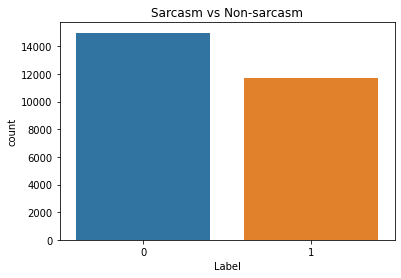

In [5]:
# Check for normalization
sns.countplot(df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [0]:
# Transform dataset to have only headline and sarcastic label
# Also split headline text into words
HEADLINE = data.Field(tokenize='spacy', include_lengths = True)
ISSARCASTIC = data.LabelField()

sarcasm_data = data.TabularDataset(
    path='/content/drive/My Drive/Deep Learning - AUA/Sarcasm Detection/Sarcasm_Headlines_Dataset.json',
    format='json',
    fields={
        'headline':('headline', HEADLINE),
        'is_sarcastic':('sarcastic', ISSARCASTIC)
    }
)

In [7]:
print(vars(sarcasm_data[0]))

{'headline': ['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', "'", 'black', 'code', "'", 'for', 'minority', 'shoppers'], 'sarcastic': 0}


In [26]:
# Not a good idea to analyse words individually
# However, it is obvious that Trump is the largest source of sarcastic headlines )))
from collections import Counter
c = Counter(" ".join(df["headline"]).split()).most_common(20)
c
# Thinking of TF-IDF for future

[('to', 8206),
 ('of', 5593),
 ('the', 5177),
 ('in', 4170),
 ('for', 3297),
 ('a', 2961),
 ('on', 2371),
 ('and', 1885),
 ('with', 1797),
 ('is', 1666),
 ('new', 1485),
 ('man', 1229),
 ('from', 1221),
 ('at', 1189),
 ('trump', 1157),
 ('about', 1051),
 ('you', 914),
 ('by', 885),
 ('this', 882),
 ('after', 838)]

In [0]:
# Split to train and test
train_data, test_data = sarcasm_data.split()

In [10]:
len(test_data)

8013

In [0]:
# Bulding vocabulary from each sequence of training data
HEADLINE.build_vocab(train_data, 
                 max_size = 50_000, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

ISSARCASTIC.build_vocab(train_data)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = 64,
    sort_key = lambda x:len(x.headline),
    sort_within_batch = True,
    device = device)

In [0]:
# recurrent neural network (RNN)
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional,
                          dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

In [0]:
# Define RNN model ( hyperparameters )
EMBEDDING_DIM = 100
PAD_IDX = HEADLINE.vocab.stoi[HEADLINE.pad_token]

model = RNN(vocab_size = len(HEADLINE.vocab), embedding_dim = EMBEDDING_DIM, hidden_dim = 256,
            output_dim = 1, n_layers = 2, bidirectional = True, dropout = 0.5, pad_idx = PAD_IDX)

In [15]:
# Print model parameters summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,512,157 trainable parameters


In [16]:
# Dense vector representation for words
pretrained_embeddings = HEADLINE.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = HEADLINE.vocab.stoi[HEADLINE.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1897,  0.0500,  0.1908,  ..., -0.3980,  0.4765, -0.1598],
        ...,
        [ 0.7841, -0.7761,  0.9107,  ...,  0.1644,  0.8103, -0.4275],
        [-0.1190,  0.1594,  1.5809,  ..., -0.8869, -1.7106, -0.2449],
        [ 0.1803, -0.1979,  0.3402,  ..., -0.2219,  0.3065, -0.2132]])


In [0]:
# Learning rate optimization
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    return correct.sum() / len(correct)

In [0]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.headline
        
        predictions = model(text, text_lengths).squeeze(1)
#         print(predictions)
        loss = criterion(predictions, batch.sarcastic.type_as(predictions))
        acc = binary_accuracy(predictions, batch.sarcastic.type_as(predictions))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
# Training the model
N_EPOCHS = 15

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # Calculated training time of this epoch
    end_time = time.time()
    elapsed_time = end_time - start_time
    epoch_mins = int(elapsed_time / 60)
    epoch_secs = int(elapsed_time - (epoch_mins * 60))
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.507 | Train Acc: 75.25%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.348 | Train Acc: 84.84%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.281 | Train Acc: 88.10%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.242 | Train Acc: 89.94%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.199 | Train Acc: 91.99%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.173 | Train Acc: 93.21%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.144 | Train Acc: 94.43%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.121 | Train Acc: 95.32%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.104 | Train Acc: 96.17%
Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 0.090 | Train Acc: 96.43%
Epoch: 11 | Epoch Time: 0m 2s
	Train Loss: 0.077 | Train Acc: 97.17%
Epoch: 12 | Epoch Time: 0m 2s
	Train Loss: 0.068 | Train Acc: 97.50%
Epoch: 13 | Epoch Time: 0m 2s
	Train Loss: 0.063 | Train Acc: 97.59%
Epoch: 14 | Epoch Time: 0m 2s
	Train Loss: 0.056 | Train Acc: 97.97%
Epoch: 15 | Epoch Time: 0m 2s
	Tra

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.headline
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.sarcastic.type_as(predictions))
            
            acc = binary_accuracy(predictions, batch.sarcastic.type_as(predictions))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
# model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.359 | Test Acc: 88.87%


In [0]:
# Give sarcasm probability of the given sentence based on our model
def predict_sarcasm(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in spacy.load('en').tokenizer(sentence)]
    indexed = [HEADLINE.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [24]:
predict_sarcasm(model, "Cats loving dogs")

0.061922043561935425